In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import pickle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import preprocessing
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

In [4]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        
        ### Convolutional section
        self.conv1 = nn.Conv2d(1, 8, 3, padding=1)
        self.conv2 = nn.Conv2d(8, 16, 5, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, return_indices=True)
        self.conv3 = nn.Conv2d(16, 32, 5, padding=0)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, return_indices=True)
        self.flatten = nn.Flatten(start_dim=1)
        self.fc1 = nn.Linear(32 * 1 * 23, 128)
        self.fc2 = nn.Linear(128, encoded_space_dim)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x, i_1 = self.pool1(self.conv2(x))
        x = F.relu(self.bn1(x))
        x, i_2 = self.pool2(self.conv3(x))
        x = F.relu(self.bn2(x))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x, i_1, i_2


class Decoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.fc1 = nn.Linear(encoded_space_dim, 128)
        self.fc2 = nn.Linear(128, 32 * 1 * 23)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 1, 23))

        self.deconv1 = nn.ConvTranspose2d(32, 16, 5, output_padding=0)
        self.bn1 = nn.BatchNorm2d(16)
        self.unpool1 = nn.MaxUnpool2d(2)
        self.deconv2 = nn.ConvTranspose2d(16, 8, 5, padding=2)
        self.bn2 = nn.BatchNorm2d(8)
        self.unpool2 = nn.MaxUnpool2d(2)
        self.deconv3 = nn.ConvTranspose2d(8, 1, 3, padding=1)
        
    def forward(self, x, unpool_i1, unpool_i2):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.unflatten(x)
        x = self.unpool1(x, unpool_i2)
        x = F.relu(self.bn1(self.deconv1(x)))
        x = self.unpool2(x, unpool_i1)
        x = F.relu(self.bn2(self.deconv2(x)))
        x = self.deconv3(x)
        return x


class Classifier(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.fc1 = nn.Linear(encoded_space_dim, 16)
        self.fc2 = nn.Linear(16, 7)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x), dim=1) #dim0=batch, dim1=element
        return x
    

class AutoEncoder(nn.Module):
    def __init__(self, encoded_space_dim):
        super().__init__()
        self.encoder = Encoder(encoded_space_dim)
        self.decoder = Decoder(encoded_space_dim)
        self.classifier = Classifier(encoded_space_dim)
        
    def forward(self, x):
        feat, i_1, i_2 = self.encoder(x)
        pred_img = self.decoder(feat, i_1, i_2)
        pred_label = self.classifier(feat)
        return feat, pred_img, pred_label

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

with open('/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/trainset.pickle', 'rb') as file:
# with open('trainset.pickle', 'rb') as file:
    trainset = pickle.load(file)

spectrogram = torch.from_numpy(trainset['spectrogram'].astype(np.float32))
texture = trainset['texture']
le = preprocessing.LabelEncoder()
labels = torch.as_tensor(le.fit_transform(texture))

train_dataset = torch.utils.data.TensorDataset(spectrogram, labels) 
train_dataloader = torch.utils.data.DataLoader( 
    dataset = train_dataset, 
    batch_size = 64,
    shuffle = True, 
    num_workers = 2, 
    ) 

mse = nn.MSELoss()
crossentropy = nn.CrossEntropyLoss()

encoder = Encoder(encoded_space_dim = 20)
decoder = Decoder(encoded_space_dim = 20)
classifier = Classifier(encoded_space_dim = 20)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()},
    {'params': classifier.parameters()}
]

optimizer = optim.Adam(params_to_optimize, lr=1e-4, weight_decay=1e-05)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=10)

encoder.to(device)
decoder.to(device)
classifier.to(device)

epoch_num = 100

Selected device: cuda


In [ ]:
from torchviz import make_dot
x = torch.randn(1, 1, 12, 100).requires_grad_(True)
autoencoder = AutoEncoder(encoded_space_dim = 20)
pred_img, pred_label = autoencoder(x)

AutoEncoderVis = make_dot((pred_img, pred_label), params=dict(list(autoencoder.named_parameters()) + [('x', x)]))
AutoEncoderVis.format = "png"
AutoEncoderVis.directory = "../vibrotactile-encoder"
AutoEncoderVis.view()

In [57]:
for epoch in range(1, epoch_num + 1):
    encoder.train(mode=True)
    decoder.train(mode=True)
    classifier.train(mode=True)

    correct = torch.zeros(1).squeeze().to(device)
    total = torch.zeros(1).squeeze().to(device)

    for i, (img, label) in enumerate(train_dataloader):
        img = torch.unsqueeze(img, 1) # Add channel axis (1 channel)
        img = img.to(device)
        label = label.to(device)

        feat, i_1, i_2 = encoder(img)
        pred_img = decoder(feat, i_1, i_2)
        pred_label = classifier(feat)

        classify_loss = crossentropy(pred_label, label)
        autoencoder_loss = mse(pred_img, img)
        loss = classify_loss + autoencoder_loss

        prediction = torch.argmax(pred_label, 1)
        correct += (prediction == label).sum().float()
        total += len(label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step(loss)
    print('Epoch: ', epoch, 'Accuracy: ', (correct/total).cpu().detach().data.numpy(), 'Autoencoder Loss: ', autoencoder_loss.item())

torch.save(encoder.state_dict(), '/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/encoder.pt')
torch.save(decoder.state_dict(), '/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/decoder.pt')
torch.save(classifier.state_dict(), '/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/classifier.pt')

Epoch:  1 Accuracy:  0.3038674 Autoencoder Loss:  1405.1363525390625
Epoch:  2 Accuracy:  0.3764641 Autoencoder Loss:  1171.202392578125
Epoch:  3 Accuracy:  0.3985359 Autoencoder Loss:  922.1015014648438
Epoch:  4 Accuracy:  0.581768 Autoencoder Loss:  799.9224243164062
Epoch:  5 Accuracy:  0.6782597 Autoencoder Loss:  707.631103515625
Epoch:  6 Accuracy:  0.67662984 Autoencoder Loss:  416.5583190917969
Epoch:  7 Accuracy:  0.67930937 Autoencoder Loss:  327.8720397949219
Epoch:  8 Accuracy:  0.68185085 Autoencoder Loss:  198.87294006347656
Epoch:  9 Accuracy:  0.6804144 Autoencoder Loss:  91.44503784179688
Epoch:  10 Accuracy:  0.6827348 Autoencoder Loss:  55.6506462097168
Epoch:  11 Accuracy:  0.6868232 Autoencoder Loss:  45.86687469482422
Epoch:  12 Accuracy:  0.6883149 Autoencoder Loss:  36.6937141418457
Epoch:  13 Accuracy:  0.68928176 Autoencoder Loss:  29.976613998413086
Epoch:  14 Accuracy:  0.6906354 Autoencoder Loss:  26.707307815551758
Epoch:  15 Accuracy:  0.7042265 Autoenc

In [5]:
autoencoder = AutoEncoder(encoded_space_dim = 20)

encoder_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/encoder.pt', map_location=torch.device('cpu'))
encoder_dict = {'encoder.' + k: v for k, v in encoder_dict.items()}

decoder_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/decoder.pt', map_location=torch.device('cpu'))
decoder_dict = {'decoder.' + k: v for k, v in decoder_dict.items()}

classifier_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/classifier.pt', map_location=torch.device('cpu'))
classifier_dict = {'classifier.' + k: v for k, v in classifier_dict.items()}

autoencoder.load_state_dict(encoder_dict, strict=False)
autoencoder.load_state_dict(decoder_dict, strict=False)
autoencoder.load_state_dict(classifier_dict, strict=False)

_IncompatibleKeys(missing_keys=['encoder.conv1.weight', 'encoder.conv1.bias', 'encoder.conv2.weight', 'encoder.conv2.bias', 'encoder.bn1.weight', 'encoder.bn1.bias', 'encoder.bn1.running_mean', 'encoder.bn1.running_var', 'encoder.conv3.weight', 'encoder.conv3.bias', 'encoder.bn2.weight', 'encoder.bn2.bias', 'encoder.bn2.running_mean', 'encoder.bn2.running_var', 'encoder.fc1.weight', 'encoder.fc1.bias', 'encoder.fc2.weight', 'encoder.fc2.bias', 'decoder.fc1.weight', 'decoder.fc1.bias', 'decoder.fc2.weight', 'decoder.fc2.bias', 'decoder.deconv1.weight', 'decoder.deconv1.bias', 'decoder.bn1.weight', 'decoder.bn1.bias', 'decoder.bn1.running_mean', 'decoder.bn1.running_var', 'decoder.deconv2.weight', 'decoder.deconv2.bias', 'decoder.bn2.weight', 'decoder.bn2.bias', 'decoder.bn2.running_mean', 'decoder.bn2.running_var', 'decoder.deconv3.weight', 'decoder.deconv3.bias'], unexpected_keys=[])

In [8]:
autoencoder.eval()
autoencoder.to(device)

correct = torch.zeros(1).squeeze().to(device)
total = torch.zeros(1).squeeze().to(device)

test_img = []
test_preds = []
test_trues = []
vib_feat = []
reconstruct_spec = []

with torch.no_grad():
    for i, (img, label) in enumerate(train_dataloader):
        img = torch.unsqueeze(img, 1) # Add channel axis (1 channel)
        img = img.to(device)
        label = label.to(device)

        feat, pred_img, pred_label = autoencoder(img)

        classify_loss = crossentropy(pred_label, label)
        autoencoder_loss = mse(pred_img, img)
        loss = classify_loss + autoencoder_loss

        pred_label = pred_label.argmax(dim=1)
        test_preds.extend(pred_label.detach().cpu().numpy())
        test_trues.extend(label.detach().cpu().numpy())
        vib_feat.extend(feat.detach().cpu().numpy())
        reconstruct_spec.extend(pred_img.detach().cpu().numpy())
        test_img.extend(img.detach().cpu().numpy())

        correct += (pred_label == label).sum().float()
        total += len(label)

print('Accuracy: ', (correct/total).cpu().detach().data.numpy(), 'Autoencoder Loss: ', autoencoder_loss.item())

Accuracy:  0.9879834 Autoencoder Loss:  13.978950500488281


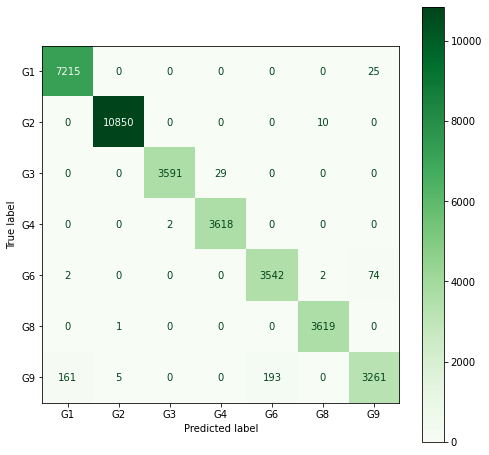

In [155]:
conf_matrix = confusion_matrix(test_trues, test_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, 
                              display_labels=['G1', 'G2', 'G3', 'G4', 'G6', 'G8', 'G9'])

fig, ax = plt.subplots(figsize=(8,8))

disp.plot(
    include_values=True,
    cmap="Greens",
    ax=ax,
    xticks_rotation="horizontal",
    values_format="d"
)

In [156]:
feat_dict = {'original_vib': test_img,
             'labels': test_trues,
             'pred_labels': test_preds,
             'vib_feat': vib_feat,
             'decoded_vib': reconstruct_spec
             }

file = open('/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/feat_dict.pickle', 'wb')
pickle.dump(feat_dict, file)
file.close()

with open('/content/drive/MyDrive/Colab Notebooks/vibrotactile-encoder/feat_dict.pickle', 'rb') as file:
    feat_dict = pickle.load(file)

True label:  5


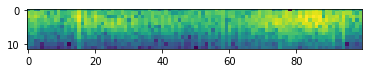

In [157]:
index = np.random.randint(0, len(train_dataloader.dataset))
print('True label: ', test_trues[index])
plt.imshow(test_img[index].squeeze())

Predicted label:  5


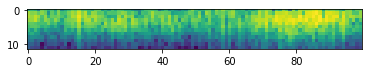

In [158]:
print('Predicted label: ', test_preds[index])
plt.imshow(reconstruct_spec[index].squeeze())

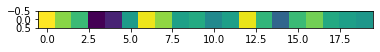

In [159]:
plt.imshow(np.expand_dims(vib_feat[index], axis=0))